# RTML Lab 2: AlexNet vs. GoogLeNet

In this lab, we will develop PyTorch implementations of AlexNet and GoogleLeNet from scratch and compare them on CIFAR-10.

## Some important terms for PyTorch and deep learning with CNNs

**Tensor**: a multidimensional matrix for calculation. Inputs, outputs, and weights are all stored as tensors. A CNN will have an "input" tensor as input (one or more images), and an "output" tensor as the output.

**Kernel**: a filter tensor or weight tensor, most often used in a convolution computation.

**Channel**: when we deal with 2D feature maps, the third-from-last dimension indexes the channel or depth dimension. A 2D image stored as a tensor has three dimensions: channel, row, and column.

**Feature**: could refer to the result of a convolution operation (feature "map") or a hand-crafted input to a model or a unit in a linear/dense/fully-connected layer.

**Feature extraction**: the process of transforming raw data into numerical features that concentrate and/or preserve the useful information in the raw data.

**Stride**: The jump necessary to go from one element to the next when performing an operation on an input tensor.

**Padding**: Additional elements added around the boundaries of a tensor to allow convolution operations or other operations to preserve size. Padding is usually with 0 elements, but other methods include copy-border and mirror reflection.

In PyTorch, we do not have to specify the input size to a convolution operation, but we do need to specify the number of input channels and the kernel size and stride. Any specific operation will lead to a specific ouptut size depending on the input size. For dense or fully-connected layers, however, we need to specify the number of input features as well as the number of output features, so it is necessary to understand how to calculate how tensor operations affect the output tensor size.

## Calculating the number of parameters and output tensor size for tensor operations

### Convolutional layer parameters

The number of parameters $k$ in a kernel for a 2D convolution operation is

$$k = k_w k_h i_c,$$

where $k_w$ is the width of the kernel, $k_h$ is the width of kernel, and $i_c$ is the number input channels.
If we have $o_c$ kernels producing $o_c$ output channels, the total number of parameters/weights can be calculated as

$$n_p = k o_c = k_w k_h i_c o_c.$$

The bias weight in a convolution operation is optional. It's not needed if you apply normalization procedures such as
batch normalization (almost always done in modern networks), but it is important if you're not using batch normalization.
In that case, the number of biases is equal to the number of kernels:

$$n_p = k_w k_h i_c o_c + o_c.$$

### Fully connected layer parameters

PyTorch separates the linear operation from the nonlinear activation function in a fully connected layer. The linear operation
is called a "linear" layer, then you have to add the activation function separately. Other frameworks such as keras use the term
"dense layer" for a fully connected layer including the nonlinear activation function.

The number of weights $s_w$ in a linear layer is

$$s_w = i_f o_f$$

or

$$s_w = i_f o_f + o_f$$

if we include a bias weight (again, not necessary if we are going to follow up with batch normalization).

It is useful to calculate the total number of parameters across all layers in a network to understand how statistically efficient it's going to be.

### Convolutional layer output tensor size

If we have an input tensor of size $w \times h \times c$ and want to perform a convolution with a $k_w \times k_h$ kernel with padding $p$ and stride $s$,
we can calculate the output tensor size as

$$\lfloor \frac{w+2p-k_w}{s} + 1 \rfloor \times \lfloor \frac{h+2p-k_h}{s} + 1 \rfloor.$$

For example, in AlexNet, the input image in the first layer is $224 \times 224 \times 3$.
A convolution of size $11 \times 11$ with padding 2 and stride 4 gives an output feature map width and height of

$$\lfloor \frac{w+2p-k_w}{s} + 1 \rfloor = \lfloor \frac{224+2(2)-11}{4} + 1 \rfloor = \lfloor 55.25 \rfloor = 55$$

## AlexNet model

From class, we now know that the AlexNet model (without splitting across GPUs) looks like this:

<img src="img/alexnet.png" title="AlexNet (Alex et al.)" style="width: 900px;" />

## AlexNet Coding in PyTorch

First, we import some necessary libraries:

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F

Next, we set up Dataset objects and DataLoader objects to load images, transform them to 3x224x224, and batch them for training/testing:

In [2]:

# Set up preprocessing of CIFAR-10 images to 3x224x224 with normalization
# using the magic ImageNet means and standard deviations. You can try
# RandomCrop, RandomHorizontalFlip, etc. during training to obtain
# slightly better generalization.

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=preprocess)

# Split the training set into training and validation sets randomly.
# CIFAR-10 train contains 50,000 examples, so let's split 80%/20%.

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

# Download the test set. If you use data augmentation transforms for the training set,
# you'll want to use a different transformer here.

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

# Dataset objects are mainly designed for datasets that can't fit entirely into memory.
# Dataset objects don't load examples into memory until their __getitem__() method is
# called. For supervised learning datasets, __getitem__() normally returns a 2-tuple
# on each call. To make a Dataset object like this useful, we use a DataLoader object
# to optionally shuffle then batch the examples in each dataset. During training.
# To keep our memory utilization small, we'll use 4 images per batch, but we could use
# a much larger batch size on a dedicated GPU. To obtain optimal usage of the GPU, we
# would like to load the examples for the next batch while the current batch is being
# used for training. DataLoader handles this by spawining "worker" threads that proactively
# fetch the next batch in the background, enabling parallel training on the GPU and data
# loading/transforming/augmenting on the CPU. Here we use num_workers=2 (the default)
# so that two batches are always ready or being prepared.

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                              shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Next, we set up to execute on a particular GPU or the CPU only:

In [3]:
# Device 'cuda' or 'cuda:0' means GPU slot 0.
# If you have more than one GPU, you can select other GPUs using 'cuda:1', 'cuda:2', etc.
# In terminal (Linux), you can check memory using in each GPU by using command
# $ nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:0


## "AlexNet" with the Sequential API

PyTorch deep learning models come in (at least) two possible styles:

<img src="img/NNinPytorch.png" style="width: 500px;" />

1. The PyTorch Sequential API is very expressive when we have a straightforward sequence of operations to perform on the input.
2. The PyTorch neural network Module allows more flexible transformations of inputs, combination of multiple inputs, generation of multiple outputs, and so on.

We will see that AlexNet (at least a simple form of AlexNet) can mostly be expressed as a Sequential process, whereas GoogLeNet, with its
parallel branches within Inception modules, requires the use of the Module API.

### The model

Let's express an AlexNet-like network using `torch.nn.Sequential`:


In [4]:
# Simple module to flatten a batched feature map tensor into a batched vector tensor

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

# AlexNet-like model using the Sequential API

NUM_CLASSES = 10

alexnet_sequential = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, NUM_CLASSES)
)

# Move model to target device

alexnet_sequential = alexnet_sequential.to(device)

At this point, by the way, it would be useful to go back to the [AlexNet paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
and ask what is missing in this version of the model?

### Training function

Next, let's write a function to train our model for some number of epochs. This one is adapted from the PyTorch tutorials.

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the train/validation dataset according to which phase we're in
            
            for inputs, labels in dataloaders[phase]:

                # Inputs is one batch of input images, and labels is a corresponding vector of integers
                # labeling each image in the batch. First, we move these tensors to our target device.
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out any parameter gradients that have previously been calculated. Parameter
                # gradients accumulate over as many backward() passes as we let them, so they need
                # to be zeroed out after each optimizer step.

                optimizer.zero_grad()

                # Instruct PyTorch to track gradients only if this is the training phase, then run the
                # forward propagation and optionally the backward propagation step for this iteration.

                with torch.set_grad_enabled(phase == 'train'):
                    # The inception model is a special case during training because it has an auxiliary
                    # output used to encourage discriminative representations in the deeper feature maps.
                    # We need to calculate loss for both outputs. Otherwise, we have a single output to
                    # calculate the loss on.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backpropagate only if in training phase

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    # Output summary statistics, load the best weight set, and return results
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

### Optimizer and loss function

Before we start training, we need to set up an optimizer object and a loss function. Typical choices for the loss function:
* For regression problems, we would normally use `nn.MSELoss()`. The equation is:
$$MSE=\frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2 $$
* For binary classification, we normally use `nn.BCELoss()`:
$$BCE=-\frac{1}{N}\sum_{i=1}^N y_i\cdot \log{\hat{y}_i} + (1-y_i)\cdot \log(1 -{\hat{y}_i})$$
* For multinomial classification, we most often use `nn.CrossEntropyLoss()`:
$$CE=-\sum_{i=1}^C t_i\cdot \log(f(s)_i),$$
where $t_i$ and $s_i$ are the ground truth and the CNN prediction for each class $i$ in $1..C$.
An activation function (Sigmoid / Softmax) is usually applied to the scores before the CE Loss computation, so $f(s)_i$ refers to the nonlinear activation function application.

For specialized needs, you can define your own loss function! We'll see examples of that later in the course.

Typical choices for the optimizer:
* SGD: Scholastic gradient descent, works well for most cases but requires appropriate values for the learning, momentum, and weight decay. Given $\alpha$ is learning rate, and $\beta$ is momentum, the equation is

$$V_t = \beta V_{t-1} + (1-\beta)\nabla_wL(W,X,y)$$
$$W_{t+1} = W_t + \alpha V_t$$

 for more information please see [Stochastic Gradient Descent with momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d)

* Adam: adaptive learning rate optimizer that usually gives superior results to SGD but sometimes doesn't work. Adam's equations are:
$$(m_t)_i=\beta_1(m_{t-1})_i+(1-\beta_1)(\nabla(W_t))_i,$$
$$(v_t)_i=\beta_2(v_{t-1})_i+(1-\beta_2)(\nabla(W_t))_i^2,$$
$$(W_{t+1})i=(W_t)_i-\alpha\frac{\sqrt{1-(\beta_2)_i^t}}{1-(\beta_i)_i^t}\frac{(m_t)_i}{\sqrt{(v_t)_i}+\epsilon}$$
* See the many other choices selected from recent deep learning papers in the [PyTorch optim documentation](https://pytorch.org/docs/stable/optim.html).


In [6]:
# CrossEntropyLoss for multinomial classification (because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = alexnet_sequential.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

## Training the model

Use train_model function for training.

In [7]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

best_model, val_acc_history, loss_acc_history = train_model(alexnet_sequential, dataloaders, criterion, optimizer, 10, 'alex_sequential_lr_0.001_bestsofar')

Epoch 0/9
----------
train Loss: 1.7464 Acc: 0.3524
Epoch time taken:  76.76025462150574
val Loss: 1.3577 Acc: 0.5049
Epoch time taken:  83.65061354637146

Epoch 1/9
----------
train Loss: 1.2213 Acc: 0.5644
Epoch time taken:  76.73192644119263
val Loss: 1.0506 Acc: 0.6226
Epoch time taken:  83.35552620887756

Epoch 2/9
----------
train Loss: 0.9679 Acc: 0.6609
Epoch time taken:  76.92400431632996
val Loss: 0.9124 Acc: 0.6828
Epoch time taken:  83.58274269104004

Epoch 3/9
----------
train Loss: 0.8160 Acc: 0.7177
Epoch time taken:  76.84008717536926
val Loss: 0.7564 Acc: 0.7386
Epoch time taken:  83.81382274627686

Epoch 4/9
----------
train Loss: 0.7024 Acc: 0.7541
Epoch time taken:  77.08730220794678
val Loss: 0.8350 Acc: 0.7128
Epoch time taken:  84.01303172111511

Epoch 5/9
----------
train Loss: 0.6233 Acc: 0.7858
Epoch time taken:  77.0996687412262
val Loss: 0.6750 Acc: 0.7672
Epoch time taken:  84.05988454818726

Epoch 6/9
----------
train Loss: 0.5447 Acc: 0.8088
Epoch time ta

## AlexNet using the Module API

The Sequential API makes it easy to create a sequential model, but not all models are sequential. For example, we need more flexibility
to create a complex model such as GoogLeNet.

Working with the `Module` API requires us to use object-oriented inheritance in Python. This means you'll have to brush up on your OO concepts or learn the basics if OOP is new to you.

We create a new class that inherits from `Module`, then in most cases, we just need to override two methods: `__init__()` and `forward()`.

`__init__()` is called the "constructor" of a class and is the method called on any Python object just after it is created, similar to constructors in Java or C++.

However, constructors and instance methods work a little differently in Python than they do in Java or C++. The constructor is just an ordinary instance method that is only special in that it
is called implicitly when the object is created. Instance methods in Python (methods called on an object) are distinguished from class methods (methods called on the class, not requiring any
instance) by the presence or absence of the `self` keyword in the parameter list. In the body of an instance method, `self` is a reference to the instance the method was called on, same as
`this` in Java or C++ or `self` in Ruby.

Anther difference between Python and other languages is that object initialization in an inheritance hierarchy is more flexible.
A constructor should normally call `super(ClassName, self).__init__()` (Python 2, also works in Python 3) or `super().__init__()` (Python 3 only) at the beginning of its
own `__init__()` method to initialze any fields used by methods in the superclass, but it need not do so.

In the case of a PyTorch `Module` subclass, we should call `super()` before doing other things.

The `forward()` method is also an instance method that is implicitly called when we invoke a `Module` instance as a function. So the code

    module = MyModule()
    
creates an instance of `MyModule` and then calls its `__init__()` method, whereas

    outputs = module(inputs)

invokes the `forward()` method defined in `MyModule`.

### The model

Here's an implementation of an AlexNet-like network.

Note that `Sequential` is itself a subclass of `Module`. This means we can use `Sequential` for a sequential flow in a larger network.

Also note that the adaptive average pool layer between the feature module and the classifier is a trick used to ensure a fixed set of 6x6 feature maps come out
of the feature extractor regardless of the input image size. It is not strictly required here (and not used in the original paper) but would allow us to use other input sizes besides 224x224 if we like.


In [34]:
class AlexNetModule(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Training the model

In [35]:
alexnet_module = AlexNet(10)
alexnet_module = alexnet.to(device)

In [36]:
# Make optimizer and Loss function
criterion_2 = nn.CrossEntropyLoss()
params_to_update_2 = alexnet_module.parameters()
optimizer_2 = optim.SGD(params_to_update_2, lr=0.001, momentum=0.9)

In [18]:
best_model2, val_acc_history2, loss_acc_history2 = train_model(alexnet, dataloaders, criterion2, optimizer2, 10, 'alex_module_lr_0.001_bestsofar')

Epoch 0/9
----------
train Loss: 0.8005 Acc: 0.7222
Epoch time taken:  74.37363409996033
val Loss: 0.7667 Acc: 0.7361
Epoch time taken:  81.21031284332275

Epoch 1/9
----------
train Loss: 0.6968 Acc: 0.7586
Epoch time taken:  72.87970519065857
val Loss: 0.7414 Acc: 0.7506
Epoch time taken:  79.862961769104

Epoch 2/9
----------
train Loss: 0.6137 Acc: 0.7868
Epoch time taken:  76.41032123565674
val Loss: 0.7180 Acc: 0.7534
Epoch time taken:  83.27066278457642

Epoch 3/9
----------
train Loss: 0.5458 Acc: 0.8103
Epoch time taken:  72.94309997558594
val Loss: 0.7124 Acc: 0.7640
Epoch time taken:  79.88523292541504

Epoch 4/9
----------
train Loss: 0.4960 Acc: 0.8270
Epoch time taken:  72.0707139968872
val Loss: 0.6915 Acc: 0.7672
Epoch time taken:  79.07196426391602

Epoch 5/9
----------
train Loss: 0.4449 Acc: 0.8461
Epoch time taken:  72.26198840141296
val Loss: 0.6603 Acc: 0.7824
Epoch time taken:  79.15270256996155

Epoch 6/9
----------
train Loss: 0.4093 Acc: 0.8586
Epoch time take

### Plot results

Based on these results, let's plot the validation loss/accuracy curves:

In [19]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

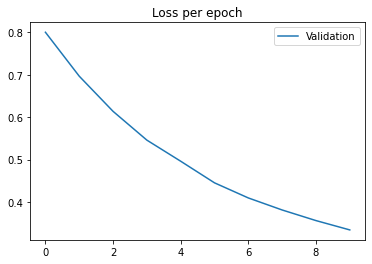

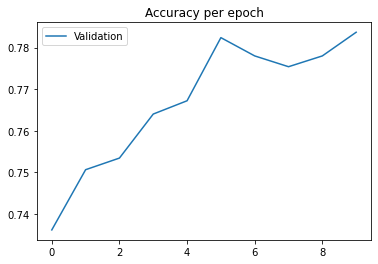

In [20]:
plot_data(val_acc_history2, loss_acc_history2)

## GoogleLeNet

Next, we'd like to construct GoogLeNet as described in the [original GoogLeNet paper](https://arxiv.org/abs/1409.4842) from scratch.

This part of the lab is adapted from [kuangliu's PyTorch CIFAR repository on GitHub](https://github.com/kuangliu/pytorch-cifar/blob/master/models/googlenet.py).

### GoogleLeNet

GoogleLeNet or Inception network is an important concept for development CNN classifier. Most of CNNs just stacked convolution deeper and deeper to get performance, but very deep networks are prone to overfitting. It also hard to pass gradient updates through the entire network, and make computation expensive. In the other hands, inception network do in wider path to improve performance.

<img src="img/expandDeeper.jpg" style="width: 400px;" />

There are several versions of the inception networks such as Inception v1, Inception v2, Inception v3, Inception v4, and Inception-ResNet.

The full architecture of GoogLeNet (inception1) looks like this:

<img src="img/GoogleLeNet.png" style="width: 1080px;" />

### Inception block

The key innovation introduced by GoogLeNet is the concept of the "inception" block. A standard inception block looks like this:

<img src="img/inception.png" style="width: 600px;" />

### Auxiliary classifiers

To prevent the middle part of the network from “dying out”, the authors introduced two auxiliary classifiers (The purple boxes in the image). They essentially applied softmax to the outputs of two of the inception modules, and computed an auxiliary loss over the same labels. The total loss function is a weighted sum of the auxiliary loss and the real loss. Weight value used in the paper was 0.3 for each auxiliary loss.

$$ \mathcal{L}_{total} = \mathcal{L}_{Real} + 0.3 \mathcal{L}_{aux_1} + 0.3 \mathcal{L}_{aux_2}$$

### Inception v1 coding

Let's implement the architecture. 
Take a look at each element and see how it implements the concepts described in the paper.
First, we begin with a `Module` for an inception block with parameters that can be customized to implement each block in the overall network.


In [41]:
class Inception(nn.Module):
    '''
    Inception block for a GoogLeNet-like CNN

    Attributes
    ----------
    in_planes : int
        Number of input feature maps
    n1x1 : int
        Number of direct 1x1 convolutions
    n3x3red : int
        Number of 1x1 reductions before the 3x3 convolutions
    n3x3 : int
        Number of 3x3 convolutions
    n5x5red : int
        Number of 1x1 reductions before the 5x5 convolutions
    n5x5 : int
        Number of 5x5 convolutions
    pool_planes : int
        Number of 1x1 convolutions after 3x3 max pooling
    b1 : Sequential
        First branch (direct 1x1 convolutions)
    b2 : Sequential
        Second branch (reduction then 3x3 convolutions)
    b3 : Sequential
        Third branch (reduction then 5x5 convolutions)
    b4 : Sequential
        Fourth branch (max pooling then reduction)
    '''
    
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.in_planes = in_planes
        self.n1x1 = n1x1
        self.n3x3red = n3x3red
        self.n3x3 = n3x3
        self.n5x5red = n5x5red
        self.n5x5 = n5x5
        self.pool_planes = pool_planes
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


### The whole shebang

Now the whole shebang.

Note that kiangliu's version is intended for CIFAR-10, so it's assuming a small input image size (3x32x32). Also, there are no side classifiers.
In the exercises, you'll convert this to the ImageNet style 224x224 input.


In [42]:
class GoogLeNet(nn.Module):
    '''
    GoogLeNet-like CNN

    Attributes
    ----------
    pre_layers : Sequential
        Initial convolutional layer
    a3 : Inception
        First inception block
    b3 : Inception
        Second inception block
    maxpool : MaxPool2d
        Pooling layer after second inception block
    a4 : Inception
        Third inception block
    b4 : Inception
        Fourth inception block
    c4 : Inception
        Fifth inception block
    d4 : Inception
        Sixth inception block
    e4 : Inception
        Seventh inception block
    a5 : Inception
        Eighth inception block
    b5 : Inception
        Ninth inception block
    avgpool : AvgPool2d
        Average pool layer after final inception block
    linear : Linear
        Fully connected layer
    '''

    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Next, here are the Dataset and DataLoader objects from kiangliu. Notice the transforms may be more suitable for CIFAR-10 than the ImageNet transforms we implemented last week. But will they work as well?

In [43]:
# Preprocess inputs to 3x32x32 with CIFAR-specific normalization parameters

preprocess = transforms.Compose([
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and set up train, validation, and test datasets with new preprocess object

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=preprocess)

train_datset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

# Create DataLoaders

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                             shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                              shuffle=False, num_workers=2)

dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

Files already downloaded and verified
Files already downloaded and verified


### Training GoogLeNet

In [44]:
googlenet = GoogLeNet().to(device)
criterion_3 = nn.CrossEntropyLoss()
params_to_update_3 = googlenet.parameters()
optimizer_3 = optim.Adam(params_to_update_3, lr=0.01)

best_model3, val_acc_history3, loss_acc_history3 = train_model(googlenet, dataloaders, criterion_3, optimizer_3, 25, 'googlenet_lr_0.01_bestsofar')

Epoch 0/24
----------
train Loss: 1.7984 Acc: 0.3280
Epoch time taken:  57.16261053085327
val Loss: 1.5263 Acc: 0.4427
Epoch time taken:  61.11941456794739

Epoch 1/24
----------
train Loss: 1.2545 Acc: 0.5399
Epoch time taken:  57.586315393447876
val Loss: 1.4846 Acc: 0.4991
Epoch time taken:  61.55653524398804

Epoch 2/24
----------
train Loss: 0.9673 Acc: 0.6539
Epoch time taken:  57.8440215587616
val Loss: 0.9725 Acc: 0.6465
Epoch time taken:  61.82408428192139

Epoch 3/24
----------
train Loss: 0.7916 Acc: 0.7185
Epoch time taken:  57.96931767463684
val Loss: 0.7206 Acc: 0.7408
Epoch time taken:  61.95615220069885

Epoch 4/24
----------
train Loss: 0.6533 Acc: 0.7708
Epoch time taken:  57.978909492492676
val Loss: 0.6759 Acc: 0.7652
Epoch time taken:  61.97967720031738

Epoch 5/24
----------
train Loss: 0.5603 Acc: 0.8032
Epoch time taken:  57.98308825492859
val Loss: 0.6697 Acc: 0.7624
Epoch time taken:  61.9776771068573

Epoch 6/24
----------
train Loss: 0.4842 Acc: 0.8315
Epoch

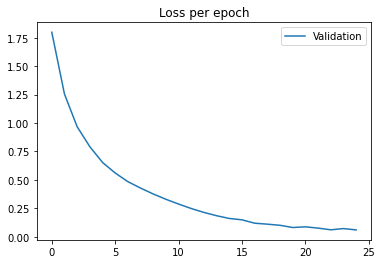

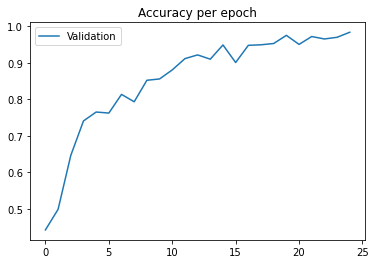

In [45]:
plot_data(val_acc_history3, loss_acc_history3)

## Exercises

1. Create VSCode projects for each of these three networks. Be sure to properly define your Python classes, with one class per file and a main module that sets up your
   objects, runs the training process, and saves the necessary data.
2. Note that the AlexNet implementation here does not have the local response normalization feature described in the paper. Take a look at the
   [PyTorch implementation of LRN](https://pytorch.org/docs/stable/generated/torch.nn.LocalResponseNorm.html) and incorporate it into your AlexNet implementation as
   it is described in the paper. Compare your test set results with and without LRN.
3. Note that the backbone of the GoogLeNet implemented thus far does not correspond exactly to the description. Modify the architecture to
   1. Use the same backbone (input image size, convolutions, etc.) before the first Inception module
   2. Add the two side classifiers
4. Compare your GoogLeNet and AlexNet implementations on CIFAR-10. Comment on the number of parameters, speed of training, and accuracy of the two models on this dataset when
   trained from scratch.
5. Experiment with the pretrained GoogLeNet from the torchvision repository. Does it give better results on CIFAR-10 similar to what we found with AlexNet last week? Comment
   on what we can glean from the results about the capacity and generalization ability of these two models.

## The report

Use the same format as last week. Describe your experiments and their results. The report should be turned in on Google Classroom before next week's lab.
